In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## Load and Transform Input Data

In [2]:
# asset price data
df_price = pd.read_excel('AssetData.xlsx', sheet_name='Sheet1')

In [3]:
df_price.head()

,Dates,Asset1,Asset2,Asset3,Asset4,Asset5,Asset6,Asset7
0,2018-11-07,5457.25,5593.924,456.281,173.6944,1226.11,289.1945,2147.45
1,2018-11-06,5457.25,5593.924,456.281,173.5643,1227.19,289.1945,2147.45
2,2018-11-05,5422.88,5578.525,456.298,174.6514,1231.49,289.1822,2148.31
3,2018-11-02,5392.53,5600.191,458.281,173.9684,1232.89,288.4757,2145.95
4,2018-11-01,5426.33,5567.267,446.660,173.3351,1233.43,289.3517,2154.29


In [4]:
df_price.tail()

,Dates,Asset1,Asset2,Asset3,Asset4,Asset5,Asset6,Asset7
3148,2006-10-13,2095.97,4161.805,278.122,306.581,590.4,187.4862,1435.27
3149,2006-10-12,2091.68,4156.308,273.561,302.524,579.3,187.7168,1436.96
3150,2006-10-11,2071.90,4139.568,271.947,301.696,573.0,187.6959,1436.25
3151,2006-10-10,2077.01,4137.883,272.080,300.518,573.0,188.3498,1438.84
3152,2006-10-09,2072.71,4132.929,270.747,303.717,577.1,188.9718,1441.94


The provided asset price file contains daily asset price data of 7 unnamed assets, starting from 10/09/2006 through 11/07/2018.

Data types are already the expected data types. No conversion needed.

In [5]:
# convert to time series
df_price = df_price.rename(columns={"Dates" : "Date"}).set_index("Date").fillna(method="ffill")

Note the original price data are sorted in descending order. Let's rearrange it so that the prices are sorted in ascending order by date.

In [6]:
df_price = df_price.sort_index()

Next, we load and transform the risk free rates.

In [7]:
# use 3-month treasury bill yield as the proxy of risk free rate
# source: https://fred.stlouisfed.org/series/DGS3MO
df_rf = pd.read_csv('DGS3MO.csv')

In [8]:
df_rf.dtypes

DATE      object
DGS3MO    object
dtype: object

In [9]:
# convert date strings to python date
df_rf['DATE'] = pd.to_datetime(df_rf['DATE'])

# convert rates from string format to numeric, also scale it from percentage to decimal
df_rf['DGS3MO'] = pd.to_numeric(df_rf['DGS3MO'], errors='coerce') / 100

# convert the data frame to a pandas time series, and fill NaN's with the last observation
df_rf = df_rf.rename(columns={"DGS3MO" : "Rf", "DATE" : "Date"}).set_index('Date').fillna(method="ffill")

## Data Analysis

In [10]:
# data statistics
df_price.describe()

,Asset1,Asset2,Asset3,Asset4,Asset5,Asset6,Asset7
count,3153.000000,3153.000000,3153.000000,3153.000000,3153.000000,3153.000000,3153.000000
mean,3001.151212,4525.224733,389.810097,256.262527,1206.831427,258.669456,1943.671170
std,1166.925865,857.665675,68.421956,68.259440,287.359573,35.284883,228.935973
min,1095.040000,2107.637000,164.514000,146.879800,573.000000,186.351600,1435.270000
25%,2116.930000,3875.832000,357.507000,182.180100,1049.250000,225.020800,1763.930000
50%,2486.840000,4636.759000,396.781000,260.329000,1233.990000,275.820100,2026.210000
75%,3856.040000,5079.809000,426.718000,295.993700,1338.590000,289.183800,2141.240000
max,5794.720000,6503.863000,573.228000,474.207000,1900.200000,298.510500,2259.660000


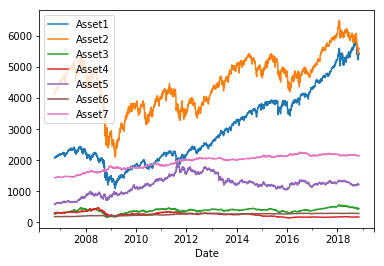

In [11]:
df_price.plot()
plt.show()

<Figure size 432x288 with 0 Axes>

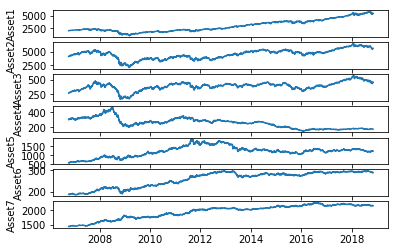

In [12]:
# since the asset index has different scale, we use subplots to look each index separately.
plt.figure()
f, axes = plt.subplots(7, 1)
axes[0].plot(df_price.index, df_price.Asset1)
axes[0].set_ylabel('Asset1')

axes[1].plot(df_price.index, df_price.Asset2)
axes[1].set_ylabel('Asset2')

axes[2].plot(df_price.index, df_price.Asset3)
axes[2].set_ylabel('Asset3')

axes[3].plot(df_price.index, df_price.Asset4)
axes[3].set_ylabel('Asset4')

axes[4].plot(df_price.index, df_price.Asset5)
axes[4].set_ylabel('Asset5')

axes[5].plot(df_price.index, df_price.Asset6)
axes[5].set_ylabel('Asset6')

axes[6].plot(df_price.index, df_price.Asset7)
axes[6].set_ylabel('Asset7')
plt.show()

* All assets index except asset 7 has a dip in 2009 great recession period, asset 7 might be some bond index
* Asset 4 has decreasing prices over past 10 years, seems some commody price index


# Calculate returns

In [13]:
# calculate daily asset returns
df_dret = df_price.pct_change()
df_dret.head()

,Asset1,Asset2,Asset3,Asset4,Asset5,Asset6,Asset7
Date,,,,,,,
2006-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-10-10,0.002075,0.001199,0.004923,-0.010533,-0.007104,-0.003291,-0.002150
2006-10-11,-0.002460,0.000407,-0.000489,0.003920,0.000000,-0.003472,-0.001800
2006-10-12,0.009547,0.004044,0.005935,0.002744,0.010995,0.000111,0.000494
2006-10-13,0.002051,0.001323,0.016673,0.013411,0.019161,-0.001228,-0.001176


In [14]:
# TODO drop partial months at the head and tail of the dataset

In [79]:
# monthly returns
df_mret = df_dret.groupby([df_dret.index.year, df_dret.index.month]).apply(lambda x: (x + 1).prod() - 1)
df_mvol = df_dret.groupby([df_dret.index.year, df_dret.index.month]).std()

In [16]:
df_mvol.head()

Asset1    Asset2    Asset3    Asset4    Asset5    Asset6  \
Date Date                                                               
2006 10    0.004065  0.003867  0.006592  0.009733  0.010191  0.002808   
     11    0.005285  0.006094  0.006465  0.009536  0.010133  0.002788   
     12    0.004180  0.003205  0.006981  0.006397  0.008214  0.002508   
2007 1     0.004490  0.007134  0.009245  0.013369  0.011072  0.002226   
     2     0.008779  0.008907  0.010443  0.009637  0.013609  0.003072   

             Asset7  
Date Date            
2006 10    0.001746  
     11    0.002047  
     12    0.001904  
2007 1     0.001485  
     2     0.002059

In [17]:
df_mret.head()

Asset1    Asset2    Asset3    Asset4    Asset5    Asset6  \
Date Date                                                               
2006 10    0.020717  0.031099  0.041334  0.027512  0.051118  0.004911   
     11    0.019020  0.029884  0.074321  0.054689  0.068249  0.012365   
     12    0.014027  0.031392  0.045029 -0.045929 -0.017438 -0.023325   
2007 1     0.015123  0.006767 -0.010558  0.002105  0.025915  0.001308   
     2    -0.019561  0.008069 -0.005936  0.033675  0.024724  0.021345   

             Asset7  
Date Date            
2006 10    0.007740  
     11    0.010447  
     12   -0.008221  
2007 1    -0.001593  
     2     0.016583

In [18]:
df_mret.tail()

Asset1    Asset2    Asset3    Asset4    Asset5    Asset6  \
Date Date                                                               
2018 7     0.037215  0.024615  0.021968 -0.021343 -0.022713 -0.004811   
     8     0.032584 -0.019313 -0.027040 -0.017705 -0.018789  0.007203   
     9     0.005692  0.008679 -0.005306  0.019176 -0.008550 -0.010531   
     10   -0.068350 -0.079592 -0.087084 -0.021588  0.020052 -0.014333   
     11    0.016344  0.011039  0.038184  0.006887  0.009343 -0.001940   

             Asset7  
Date Date            
2018 7    -0.004184  
     8     0.007650  
     9    -0.009337  
     10   -0.004777  
     11   -0.002063

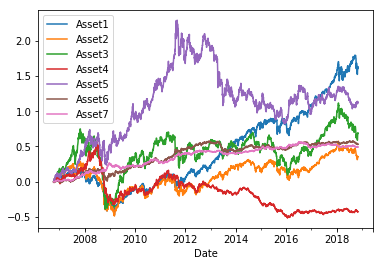

In [19]:
# plot asset cumulative returns
CumulativeReturns = ((1+df_dret).cumprod()-1)
CumulativeReturns.plot()
plt.show()

Calculate pairwise correlations of all assets.

In [20]:
correlations = df_mret.corr()

In [70]:
#correlations. Asset1 and Asset2 has high correlation

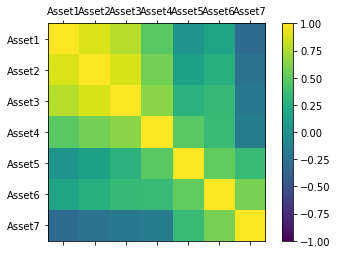

In [21]:
# plot correlation matrix
names = df_mret.columns
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,7,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

Scatterplots

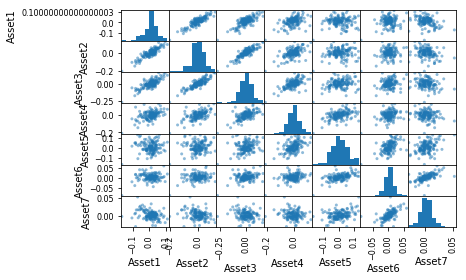

In [22]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_mret)
plt.show()

In [23]:
# return statistics
df_mret.describe()

,Asset1,Asset2,Asset3,Asset4,Asset5,Asset6,Asset7
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,0.007516,0.003357,0.005642,-0.002644,0.006511,0.003061,0.002799
std,0.041322,0.050165,0.063609,0.047990,0.051876,0.016891,0.011645
min,-0.167951,-0.201783,-0.273677,-0.212832,-0.168896,-0.086914,-0.029161
25%,-0.013965,-0.019609,-0.026356,-0.027678,-0.024180,-0.005018,-0.003615
50%,0.013265,0.008267,0.003522,0.001324,0.004466,0.003365,0.001203
75%,0.032278,0.031824,0.040992,0.025504,0.040433,0.011003,0.008910
max,0.109292,0.128041,0.170869,0.130045,0.130137,0.058448,0.053071


## Portfolio Optimization


Assumptions

* Historical returns are used as the proxy for expected returns of assets
* Historical covariances are used as the proxy for expected covariances between assets

In [24]:
#calculate annulized assets return
R_exp = df_mret.mean() * 12

In [25]:
R_vol=df_mvol.mean() * 12

In [26]:
# assets risk adjusted return
R_sharpe=R_exp/(R_vol*R_vol)

In [27]:
CovMat_exp = np.cov(df_mret, rowvar=False)

In [28]:
def port_return(w, R):
    return np.sum(w * R)

In [29]:
n_assets = df_mret.columns.size

In [30]:
w = np.array([1./n_assets] * n_assets)

In [31]:
# mean risk free rate
rf_mean=df_rf.groupby([df_rf.index.year,df_rf.index.month]).mean().mean()
print(rf_mean)

Rf    0.008819
dtype: float64


In [32]:
# simple equal weighting allocation
port_return(w, R_exp)

0.04498528960471392

In [33]:
def port_vol(w, Cov):
    return np.sqrt(np.dot(w.T, np.dot(Cov, w)))

In [34]:
port_vol(w, CovMat_exp)

0.02975852475059659

In [35]:
def min_fun(w, R, Cov):
    return -1 * (port_return(w, R)-rf_mean) / port_vol(w, Cov)

In [36]:
from scipy.optimize import minimize

def port_optimize(R, Cov, min_wt = 0.05, max_wt = 0.2, req_ret = 0.05):
    """Maximize the sharpe ratio to find the optimal weights"""
    n_assets = R.size
    
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}, 
            {'type': 'ineq', 'fun': lambda x: port_return(x, R) - req_ret})
    
    bnds = tuple((min_wt, max_wt) for x in range(n_assets))
    
    opt = minimize(min_fun,
                   x0=np.array([1./n_assets] * n_assets),
                   args=(R, Cov),
                   method='SLSQP',
                   bounds=bnds,
                   constraints=cons)

    opt_weights = opt['x']

    return  opt_weights

In [37]:
#Scenario 1 Assume all assets needs to be picked
opt_weight = port_optimize(R_exp, CovMat_exp, min_wt = 0.05, max_wt=1.,req_ret=0)
print(np.round(opt_weight, decimals=2))
np.sum(opt_weight)

[0.14 0.05 0.05 0.05 0.05 0.05 0.61]


1.0000000000004714

In [38]:
port_return(opt_weight, R_exp)

0.04276722130519778

In [39]:
port_vol(opt_weight, CovMat_exp)

0.014421337626090566

In [40]:
#Scenario2 Assume the minimum annualized return requirement is 6%
opt_weight = port_optimize(R_exp, CovMat_exp, min_wt = 0.05, max_wt=1.,req_ret = 0.06)
print(np.round(opt_weight, decimals=2))
print(port_return(opt_weight,R_exp))
print(port_vol(opt_weight,CovMat_exp))

[0.36 0.05 0.05 0.05 0.16 0.05 0.28]
0.059999999784723895
0.024013782566867554


In [78]:
# backtesting three strategies. Assume we use the asset allocation weighting from the beginning of the performance window,
# and rebalance once every month. We can compare which strategy produced the best cumulative return

In [69]:
#strategy1
opt_weight = port_optimize(R_exp, CovMat_exp, min_wt = 0.05, max_wt=1.,req_ret=0)
print(np.round(opt_weight,decimals=2))

In [73]:
df_port_mret = pd.DataFrame(index=df_mret.index)

In [76]:
df_port_mret['strat1'] = np.dot(df_mret, opt_weight)

In [80]:
#strategy2
opt_weight = port_optimize(R_exp, CovMat_exp, min_wt = 0.05, max_wt=1.,req_ret=0.06)
print(np.round(opt_weight,decimals=2))

[0.36 0.05 0.05 0.05 0.16 0.05 0.28]


In [83]:
df_port_mret['strat2'] = np.dot(df_mret, opt_weight)

In [85]:
#strategy3 equal weighted
opt_weight=np.array([1/7]*7)
print(np.round(opt_weight, decimals=2))

[0.14 0.14 0.14 0.14 0.14 0.14 0.14]


In [86]:
df_port_mret['strat3'] = np.dot(df_mret, opt_weight)

In [129]:
# Strategy 4: Risk Parity
df_rolling_mvol = df_mret.rolling(window=12).std() * 12

In [130]:
# Cheat a little. Use the first available month of standard deviations to backfill earlier months with NAs
filler = df_rolling_mvol.iloc[11:12].values.flatten()
for i in range(11):
    df_rolling_mvol.iloc[i] = filler

In [144]:
inv_vol = (1 / df_rolling_mvol)
row_sum = inv_vol.sum(axis=1).values
df_wts = inv_vol.divide(row_sum, axis=0)

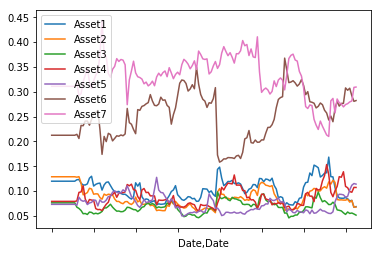

In [156]:
df_wts.plot()

In [153]:
df_port_mret['strat4'] = (df_mret * df_wts).sum(axis=1)

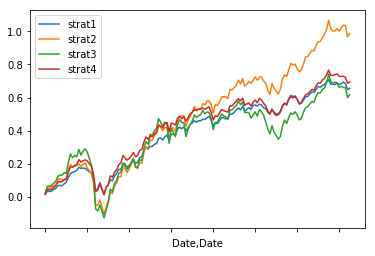

In [154]:
((df_port_mret + 1).cumprod() - 1).plot()

In [161]:
(df_port_mret.mean() * 12) / (df_port_mret.std() * 12)

strat1    0.247129
strat2    0.208214
strat3    0.125973
strat4    0.212408
dtype: float64

* Stratrgy 2 has largest cumulative,because we have set up the minimal return requirement, but express higher variance compared to strategy 1. 
* Stragegy 1 has less volatility in return with minder cumulative return compared to strategy2. 
* Simple equal weighting Allocation has the worst risk adjusted return.

In [281]:
# calculate max drawdown curves
cum_max = df_mret.iloc[:,7:10].max()
cum_min = min(df_mret.iloc[:,7:10])
print(cum_max,cum_min)


mCumulativeReturns1 CumulativeReturns2
